<a href="https://colab.research.google.com/github/anunknownpleasure/Pricing-assets-with-deep-learning/blob/main/Asset_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Installing libraries


In [2]:
!pip install -q getFamaFrenchFactors pandas_datareader lxml

# 2. Data Import and preprocessing

## 2a. Importing Fama-French 5 factor data


In [3]:
import numpy as np
import pandas as pd
import getFamaFrenchFactors

print("Successfully imported getFamaFrenchFactors!")
print(dir(getFamaFrenchFactors))

Successfully imported getFamaFrenchFactors!
['BeautifulSoup', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__warningregistry__', 'all_factor_links', 'all_factors_text', 'bold_tags', 'carhart4Factor', 'csv_links', 'factor_dict', 'famaFrench3Factor', 'famaFrench5Factor', 'ff3factor_dict', 'home_url', 'link', 'links_for_factor', 'momAndOthers_dict', 'momentumFactor', 'pd', 'relativedelta', 'requests', 'response', 'sib', 'soup', 'text', 'text_to_search', 'txt_links', 'url']


In [4]:
from getFamaFrenchFactors import famaFrench5Factor


# Get the factors
factors_df = famaFrench5Factor()

# Adjust from percentage
factors_df[['Mkt-RF', 'SMB', 'HML', 'RF']] = factors_df[['Mkt-RF', 'SMB', 'HML', 'RF']] / 100



In [5]:
factors_df.head(20)

,date_ff_factors,Mkt-RF,SMB,HML,RMW,CMA,RF
0,1963-07-31,-0.000039,-0.000048,-0.000081,0.0064,-0.0115,0.000027
1,1963-08-31,0.000508,-0.000080,0.000170,0.0040,-0.0038,0.000025
2,1963-09-30,-0.000157,-0.000043,0.000000,-0.0078,0.0015,0.000027
3,1963-10-31,0.000254,-0.000134,-0.000004,0.0279,-0.0225,0.000029
4,1963-11-30,-0.000086,-0.000085,0.000173,-0.0043,0.0227,0.000027
5,1963-12-31,0.000183,-0.000189,-0.000021,0.0012,-0.0025,0.000029
6,1964-01-31,0.000227,0.000010,0.000163,0.0021,0.0148,0.000030
7,1964-02-29,0.000155,0.000033,0.000281,0.0011,0.0081,0.000026
8,1964-03-31,0.000141,0.000141,0.000329,-0.0203,0.0298,0.000031
9,1964-04-30,0.000011,-0.000148,-0.000054,-0.0132,-0.0113,0.000029


We adjust the start date to -1-31-1964

In [6]:
FFdata = factors_df.iloc[6:]
FFdata['date_ff_factors'] = pd.to_datetime(FFdata['date_ff_factors'])
FFdata = FFdata.set_index('date_ff_factors')

/tmp/ipython-input-4197135584.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FFdata['date_ff_factors'] = pd.to_datetime(FFdata['date_ff_factors'])


## 2b. Importing the macroeconomic data

In [7]:
import pandas_datareader.data as web

# --- 1. Define the 5 Long-History Macro Indicators (FRED Tickers) ---
long_macro_tickers = {
    'Term_Spread': 'T10YFFM',      # 10-Yr Yield minus Fed Funds Rate
    'Default_Spread': 'AAAFFM',     # Baa Corp Yield minus Aaa Corp Yield (Risk Aversion Proxy)
    'Ind_Production': 'INDPRO',     # Industrial Production Index
    'Unemployment': 'UNRATE',       # Civilian Unemployment Rate
    'Consumer_Sentiment': 'UMCSENT' # University of Michigan Consumer Sentiment
}

# --- 2. Define the Time Period
start_date = '1964-01-01'
end_date = '2025-08-31'

# --- 3. Fetch Data from FRED ---
try:
    macro_data = web.DataReader(
        list(long_macro_tickers.values()),
        'fred',
        start=start_date,
        end=end_date
    )
    macro_data.columns = list(long_macro_tickers.keys())

except Exception as e:
    print(f"Error fetching data from FRED: {e}")
    macro_data = pd.DataFrame(index=pd.date_range(start_date, end_date, freq='M'))

# --- 4. Align Data to Monthly Frequency ---

# 4a. Forward-Fill any monthly gaps (common in macro data)
macro_data = macro_data.ffill()

# 4b. Ensure all data points are at the end of the month for clean alignment
macro_data = macro_data.resample('ME').last()


# --- 5. Display the result ---
print(f"Macro Data Imported and Aligned ({len(macro_data)} periods, starting {macro_data.index.min().strftime('%Y-%m')}):")
print(macro_data.head())
print("\n... and the tail:")
print(macro_data.tail())

# The resulting 'macro_data' DataFrame is ready for merging with Fama-French data.

Macro Data Imported and Aligned (740 periods, starting 1964-01):
            Term_Spread  Default_Spread  Ind_Production  Unemployment  \
DATE                                                                    
1964-01-31         0.69            0.91         27.7409           5.6   
1964-02-29         0.67            0.88         27.9291           5.4   
1964-03-31         0.79            0.95         27.9291           5.4   
1964-04-30         0.76            0.93         28.3861           5.3   
1964-05-31         0.70            0.91         28.5474           5.1   

            Consumer_Sentiment  
DATE                            
1964-01-31                 NaN  
1964-02-29                99.5  
1964-03-31                99.5  
1964-04-30                99.5  
1964-05-31                98.5  

... and the tail:
            Term_Spread  Default_Spread  Ind_Production  Unemployment  \
DATE                                                                    
2025-04-30        -0.05    

In [8]:
print(macro_data.shape, FFdata.shape)

(740, 5) (740, 6)


##2c. Importing the FF-portfolios

In [9]:
# --- 1. Define Time Period ---
# Must match the start date used for your FF factors and macro data (e.g., 1964-01-01)
start_date = '1964-01-01'
end_date = '2025-08-31'

# --- 2. Fetch the 25 Portfolios (Size x Book-to-Market) ---
# The data is downloaded as a dictionary object
ff_portfolio = web.DataReader(
    '25_Portfolios_5x5',
    'famafrench',
    start=start_date,
    end=end_date
)

df_returns_25 = ff_portfolio[0]

df_returns_25 = df_returns_25.replace([-99.99, -999], np.nan) # Missing values are indicated by -99.99 or -999
df_returns_25.dropna(inplace=True)

df_returns_25 = (df_returns_25/100)# Converting from percentage to fraction

# Convert PeriodIndex to DatetimeIndex at the end of the month
df_returns_25.index = df_returns_25.index.to_timestamp(how = 'end').date




/tmp/ipython-input-3312524815.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_portfolio = web.DataReader(
/tmp/ipython-input-3312524815.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_portfolio = web.DataReader(
/tmp/ipython-input-3312524815.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_portfolio = web.DataReader(
/tmp/ipython-input-3312524815.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'obje

## 2d. Combining all the data into a DataFrame

In [10]:
# Making the index into a datetime object
macro_data.index = pd.to_datetime(macro_data.index)


# Combine the dataframes using merge on the index

combined_data_FF_macro = pd.merge(FFdata, macro_data, left_index=True, right_index=True, how='inner') # Combining FF and Macro. Dropping first row because of a null value

combined_data = pd.merge(combined_data_FF_macro, df_returns_25, left_index=True, right_index=True, how='inner')

combined_data.dropna(inplace=True) # Dropping NaN entries

# Display the combined data
print("Combined Data:")
display(combined_data.head())
print("\n... and the tail:")
display(combined_data.tail())

Combined Data:


,Mkt-RF,SMB,HML,RMW,CMA,RF,Term_Spread,Default_Spread,Ind_Production,Unemployment,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
date_ff_factors,,,,,,,,,,,,,,,,,,,,,
1964-02-29,0.000155,0.000033,0.000281,0.0011,0.0081,0.000026,0.67,0.88,27.9291,5.4,...,0.025943,0.015619,0.028444,0.072047,0.046121,0.018271,0.005232,0.010194,0.039989,0.037567
1964-03-31,0.000141,0.000141,0.000329,-0.0203,0.0298,0.000031,0.79,0.95,27.9291,5.4,...,0.017750,0.029767,0.052497,0.071287,0.007247,0.011575,0.007635,0.036237,0.038382,0.001491
1964-04-30,0.000011,-0.000148,-0.000054,-0.0132,-0.0113,0.000029,0.76,0.93,28.3861,5.3,...,-0.027045,0.003434,0.019784,-0.026384,-0.022805,0.002272,0.014745,0.008082,-0.009054,0.024147
1964-05-31,0.000141,-0.000062,0.000181,-0.0015,0.0013,0.000026,0.70,0.91,28.5474,5.1,...,0.011914,0.022992,0.013559,0.013281,0.040990,0.020599,0.003304,0.011776,0.042859,0.033968
1964-06-30,0.000127,0.000013,0.000068,-0.0033,0.0010,0.000030,0.67,0.91,28.6280,5.2,...,0.010927,0.014771,0.011035,0.024965,0.031119,0.009744,0.028644,0.004437,0.013682,0.024217



... and the tail:


,Mkt-RF,SMB,HML,RMW,CMA,RF,Term_Spread,Default_Spread,Ind_Production,Unemployment,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
date_ff_factors,,,,,,,,,,,,,,,,,,,,,
2025-04-30,-0.000084,-0.000186,-0.000340,-0.0285,-0.0267,0.000035,-0.05,1.12,103.6224,4.2,...,-0.008766,-0.012699,-0.020146,-0.039276,-0.072668,0.014106,-0.030129,-0.073867,-0.013472,-0.027941
2025-05-31,0.000606,-0.000072,-0.000288,0.0126,0.0251,0.000038,0.09,1.21,103.6570,4.2,...,0.062577,0.050222,0.035353,0.081175,0.065826,0.078077,0.061296,0.018407,0.026156,0.065684
2025-06-30,0.000486,-0.000002,-0.000160,-0.0319,0.0145,0.000034,0.05,1.13,104.2115,4.1,...,0.020351,0.043192,0.024175,0.073815,0.058024,0.055279,0.062451,0.047405,0.036424,0.070109
2025-07-31,0.000198,-0.000015,-0.000127,-0.0029,-0.0207,0.000034,0.06,1.12,103.8194,4.2,...,0.034206,0.021766,0.009013,-0.001069,-0.019303,0.032949,0.014068,0.012224,0.002333,-0.013744
2025-08-31,0.000185,0.000488,0.000441,-0.0069,0.0207,0.000038,-0.07,1.02,103.9203,4.3,...,0.036524,0.016164,0.023481,0.058848,0.071342,0.011610,0.011927,0.030567,0.054257,0.090799


In [11]:
combined_data.columns

Index(['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'Term_Spread',
       'Default_Spread', 'Ind_Production', 'Unemployment',
       'Consumer_Sentiment', 'SMALL LoBM', 'ME1 BM2', 'ME1 BM3', 'ME1 BM4',
       'SMALL HiBM', 'ME2 BM1', 'ME2 BM2', 'ME2 BM3', 'ME2 BM4', 'ME2 BM5',
       'ME3 BM1', 'ME3 BM2', 'ME3 BM3', 'ME3 BM4', 'ME3 BM5', 'ME4 BM1',
       'ME4 BM2', 'ME4 BM3', 'ME4 BM4', 'ME4 BM5', 'BIG LoBM', 'ME5 BM2',
       'ME5 BM3', 'ME5 BM4', 'BIG HiBM'],
      dtype='object')

In [12]:
FF_columns = combined_data.columns[:6]
macro_columns = combined_data.columns[6:11]
portfolio_columns = combined_data.columns[11:]

no_of_FF_features = len(FF_columns)
no_macro_features = len(macro_columns)
no_of_portfolios = len(portfolio_columns)




## 2e. Data Processing

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


processed_data = scaler.fit_transform(combined_data)
processed_data[:5]

processed_data.shape


(739, 36)

We create rolling windows for LSTM input

In [14]:
# Function to create rolling windows on a timeseries data

def rolling_window(data, lookback):
  x_rolling = []
  for i in range(len(data) - lookback):
    x_rolling.append(data[i: i + lookback])

  return np.array(x_rolling)

lookback = 12
ff_data = processed_data[:, :no_of_FF_features]
macro_data = processed_data[:, no_of_FF_features: no_of_FF_features + no_macro_features]
portfolio_data = processed_data[:, no_of_FF_features + no_macro_features:]

# Creating rolling window on macro data
X_macro_rolled = rolling_window(macro_data, lookback)

# Aligning the rolling data with FF factor and Portfolio data
X_ff_aligned = ff_data[lookback:]
Y_targets_aligned = portfolio_data[lookback:]




In [15]:
# Creating Dataset

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset # Import Subset

class AssetPricingDataset(Dataset):

    def __init__(self, macro_data, ff_data, target_data):
        # 1. Convert all data to PyTorch tensors
        #    We use .float() for all data as they are continuous variables.
        self.X_macro = torch.tensor(macro_data).float()
        self.X_ff = torch.tensor(ff_data).float()
        self.Y_targets = torch.tensor(target_data).float()

    def __len__(self):
        return len(self.X_macro)

    def __getitem__(self, idx):
        return {
            'macro_X': self.X_macro[idx],    # Shape: [12, 5]
            'ff_X': self.X_ff[idx],          # Shape: [6]
            'target_Y': self.Y_targets[idx]  # Shape: [25]
        }

data = AssetPricingDataset(X_macro_rolled, X_ff_aligned, Y_targets_aligned)
no_of_samples = len(data)
train_size = int(len(data)*0.8)

# Use Subset to create train and test datasets
indices = list(range(no_of_samples))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_data = Subset(data, train_indices)
test_data = Subset(data, test_indices)


BATCH_SIZE = 64

train_dataset = DataLoader(dataset = train_data, batch_size=BATCH_SIZE, shuffle = True, drop_last = True)
test_dataset = DataLoader(dataset = test_data, batch_size=BATCH_SIZE, shuffle = False, drop_last = False)

# **Model training**

In [16]:
class Generator(nn.Module):
    """
    Generator (SDF Network)

    Inputs:
    - macro_X: Macro time series [batch, seq_len, macro_dim]
    - ff_X: Fama-French factors [batch, ff_dim]

    Output:
    - omega: SDF portfolio weights [batch, num_assets]
    - h_t: Hidden macro states [batch, hidden_dim]
    """
    def __init__(self, macro_dim, ff_dim, hidden_dim, lstm_layers, num_assets):
        super().__init__()

        # LSTM for processing macro time series
        self.lstm = nn.LSTM(
            input_size=macro_dim,
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=0.2 if lstm_layers > 1 else 0
        )

        # Feedforward network: [hidden_states + FF_factors] -> portfolio_weights
        self.fc1 = nn.Linear(hidden_dim + ff_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.activation = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.3)

        # Output layer: portfolio weights for each asset
        self.fc2 = nn.Linear(hidden_dim, num_assets)

    def forward(self, macro_X, ff_X):
        # Process macro time series with LSTM
        _, (h_n, c_n) = self.lstm(macro_X)
        h_t = h_n[-1]  # Take last hidden state

        # Combine macro states with FF factors
        combined = torch.cat([h_t, ff_X], dim=1)

        # Feedforward layers
        x = self.fc1(combined)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.dropout(x)

        # Output: portfolio weights (omega)
        omega = self.fc2(x)

        return omega, h_t


class Discriminator(nn.Module):
    """
    Discriminator (Conditioning Network)

    Inputs:
    - h_t: Hidden macro states [batch, hidden_dim]
    - ff_X: FF factors [batch, ff_dim]

    Output:
    - g: Conditioning instruments [batch, num_instruments]
    """
    def __init__(self, hidden_dim, ff_dim, num_instruments, hidden_layer):
        super().__init__()

        input_dim = hidden_dim + ff_dim

        self.fc1 = nn.Linear(input_dim, hidden_layer)
        self.bn1 = nn.BatchNorm1d(hidden_layer)
        self.fc2 = nn.Linear(hidden_layer, hidden_layer // 2)
        self.bn2 = nn.BatchNorm1d(hidden_layer // 2)
        self.fc3 = nn.Linear(hidden_layer // 2, num_instruments)
        self.activation = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, h_t, ff_X):
        # Combine macro states with FF factors
        x = torch.cat([h_t, ff_X], dim=1)

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.dropout(x)

        # Output: conditioning instruments
        g = torch.tanh(self.fc3(x))  # Bounded in [-1, 1]

        return g

In [17]:
# Loss function

def calculate_SDF(weights, returns):

  weighted_returns = (weights*returns).sum(dim=1, keepdim=True)
  sdf_m = 1 - weighted_returns

  return sdf_m

def no_arbitrage_loss(weights, returns, g_instruments, num_assets):

  sdf = calculate_SDF(weights, returns)
  g_expanded = g_instruments.mean(dim=1, keepdim=True).expand(-1, num_assets)
  pricing_errors = sdf*returns*g_expanded
  mean_errors = pricing_errors.mean(dim = 0)
  loss = (mean_errors**2).mean()
  return loss


def discriminator_loss(weights, returns, g_instruments, num_assets):

  na_loss = no_arbitrage_loss(weights, returns, g_instruments, num_assets)
  D_regularization_term = 0.01*(g_instruments**2).mean()

  return -na_loss + D_regularization_term

def generator_loss(weights, returns, g_instruments, num_assets):

  na_loss = no_arbitrage_loss(weights, returns, g_instruments, num_assets)
  G_regularization_term = 0.01*(weights**2).mean()

  return na_loss + G_regularization_term



In [18]:
import torch.optim as optim
# training loop

def training(generator, discriminator, train_loader, epochs, d_lr, g_lr):
  D_optim = optim.Adam(discriminator.parameters(), lr = d_lr)
  G_optim = optim.Adam(generator.parameters(), lr = g_lr)

  d_losses = []
  g_losses = []

  generator.train()
  discriminator.train()

  for epoch in range(epochs):
    epoch_g_loss = 0
    epoch_d_loss = 0
    num_batches = 0

    for batch in train_loader:
      macro_X = batch['macro_X']
      ff_X = batch['ff_X']
      returns = batch['target_Y']

    # Training the discriminator (trained twice)
      for i in range(2):
        D_optim.zero_grad()

        # Generate SDF weights
        weights, h_t = generator(macro_X, ff_X)

        # Generate conditioning instruments
        g_inst = discriminator(h_t.detach(), ff_X)

        # Compute discriminator loss (weights are detached to above updating generator weights)
        d_loss = discriminator_loss(weights.detach(), returns, g_inst, no_of_portfolios)

        # Backprop on discriminator
        d_loss.backward()
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
        D_optim.step()


    # Training the generator
      G_optim.zero_grad()
    # Generate SDF weights
      weights, h_t = generator(macro_X, ff_X)

    # Conditioning instruments
      g_inst = discriminator(h_t.detach(), ff_X)
    # Computer generator loss
      g_loss = generator_loss(weights, returns, g_inst.detach(), no_of_portfolios)
    # Backprop on generator
      g_loss.backward()
      torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
      G_optim.step()

      epoch_g_loss += g_loss.item()
      epoch_d_loss += d_loss.item()
      num_batches += 1

    # Average losses in an epoch

    avg_g_loss = epoch_g_loss / num_batches
    avg_d_loss = epoch_d_loss / num_batches

    g_losses.append(avg_g_loss)
    d_losses.append(avg_d_loss)

    # Moniter the loss
    if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}], G Loss: {avg_g_loss:.6f}, D Loss: {avg_d_loss:.6f}')

  return g_losses, d_losses



# **Baseline models**

## 1. Fama-French linear model

In [19]:
from sklearn.linear_model import LinearRegression

def baseline_fama_french_5(train_loader, test_loader):
    """
    Baseline 1: Fama-French 5-Factor Model

    Traditional factor model:
    R_i,t = α_i + β'·F_t + ε_i,t
    """
    print("\n" + "="*60)
    print("BASELINE 1: Fama-French 5-Factor Model")
    print("="*60)

    # Collect all data
    train_returns = []
    train_ff = []
    test_returns = []
    test_ff = []

    for batch in train_loader:
        train_returns.append(batch['target_Y'].numpy())
        train_ff.append(batch['ff_X'].numpy())

    for batch in test_loader:
        test_returns.append(batch['target_Y'].numpy())
        test_ff.append(batch['ff_X'].numpy())

    train_returns = np.concatenate(train_returns, axis=0)
    train_ff = np.concatenate(train_ff, axis=0)
    test_returns = np.concatenate(test_returns, axis=0)
    test_ff = np.concatenate(test_ff, axis=0)

    # Use first 5 FF factors (excluding RF)
    train_ff = train_ff[:, :5]  # Mkt-RF, SMB, HML, RMW, CMA
    test_ff = test_ff[:, :5]

    # Estimate factor loadings for each portfolio
    betas = []
    alphas = []

    for i in range(train_returns.shape[1]):
        model = LinearRegression()
        model.fit(train_ff, train_returns[:, i])
        betas.append(model.coef_)
        alphas.append(model.intercept_)

    betas = np.array(betas)
    alphas = np.array(alphas)

    # Create SDF = mean-variance efficient combination of factors
    mean_factors = train_ff.mean(axis=0)
    cov_factors = np.cov(train_ff.T)

    try:
        weights = np.linalg.solve(cov_factors, mean_factors)
        train_sdf_returns = (train_ff @ weights).flatten()
        test_sdf_returns = (test_ff @ weights).flatten()
    except:
        # If singular, use equal weights
        train_sdf_returns = train_ff.mean(axis=1)
        test_sdf_returns = test_ff.mean(axis=1)

    # Compute metrics
    train_sharpe = (train_sdf_returns.mean() / train_sdf_returns.std()) * np.sqrt(12)
    test_sharpe = (test_sdf_returns.mean() / test_sdf_returns.std()) * np.sqrt(12)
    avg_alpha = np.abs(alphas).mean()

    print(f"Train Sharpe Ratio: {train_sharpe:.4f}")
    print(f"Test Sharpe Ratio: {test_sharpe:.4f}")
    print(f"Average |Alpha|: {avg_alpha:.6f}")

    return {
        'train_sharpe': train_sharpe,
        'test_sharpe': test_sharpe,
        'avg_alpha': avg_alpha,
        'train_returns': train_sdf_returns,
        'test_returns': test_sdf_returns
    }

## 2. Mean-Variance portfolio

In [20]:
def baseline_linear_mv(train_loader, test_loader):
    """
    Baseline 2: Simple Linear Mean-Variance Portfolio

    Maximize: ω'μ - λ·ω'Σω
    """
    print("\n" + "="*60)
    print("BASELINE 2: Linear Mean-Variance Portfolio")
    print("="*60)

    # Collect returns
    train_returns = []
    test_returns = []

    for batch in train_loader:
        train_returns.append(batch['target_Y'].numpy())

    for batch in test_loader:
        test_returns.append(batch['target_Y'].numpy())

    train_returns = np.concatenate(train_returns, axis=0)
    test_returns = np.concatenate(test_returns, axis=0)

    # Estimate mean and covariance
    mean_ret = train_returns.mean(axis=0)
    cov_mat = np.cov(train_returns.T)

    # Solve for tangency portfolio
    try:
        inv_cov = np.linalg.inv(cov_mat)
        weights = inv_cov @ mean_ret
        weights = weights / np.abs(weights).sum()
    except:
        weights = np.ones(train_returns.shape[1]) / train_returns.shape[1]

    # Portfolio returns
    train_portfolio_ret = (train_returns @ weights).flatten()
    test_portfolio_ret = (test_returns @ weights).flatten()

    # Compute Sharpe ratios
    train_sharpe = (train_portfolio_ret.mean() / train_portfolio_ret.std()) * np.sqrt(12)
    test_sharpe = (test_portfolio_ret.mean() / test_portfolio_ret.std()) * np.sqrt(12)

    print(f"Train Sharpe Ratio: {train_sharpe:.4f}")
    print(f"Test Sharpe Ratio: {test_sharpe:.4f}")
    print(f"Portfolio weights range: [{weights.min():.4f}, {weights.max():.4f}]")

    return {
        'train_sharpe': train_sharpe,
        'test_sharpe': test_sharpe,
        'weights': weights,
        'train_returns': train_portfolio_ret,
        'test_returns': test_portfolio_ret
    }


# **Evaluation**

## 1. Evaluation metrics

In [23]:
def evaluate_GAN(generator, test_loader):

    generator.eval()
    all_sdf = []
    all_returns = []
    all_predictions = []

    with torch.no_grad():
        for batch in test_loader:
            macro = batch['macro_X']
            char = batch['ff_X']
            returns = batch['target_Y']

            # Get SDF weights
            sdf_weights = generator(macro, char)

            # Construct SDF
            sdf = 1 - (sdf_weights * returns).sum(dim=1)

            all_sdf.append(sdf.numpy())
            all_returns.append(returns.numpy())
            all_predictions.append(sdf_weights.numpy())

    sdf = np.concatenate(all_sdf)
    returns = np.concatenate(all_returns)
    predictions = np.concatenate(all_predictions)

    # Compute metrics
    results = {}

    # 1. Sharpe Ratio
    portfolio_returns = (predictions * returns).sum(axis=1)
    results['sharpe_ratio'] = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(12)

    # 2. Cross-sectional R²
    mean_returns = returns.mean(axis=0)
    pred_returns = predictions.mean(axis=0) @ mean_returns
    results['cross_sectional_r2'] = 1 - np.sum((mean_returns - pred_returns)**2) / np.sum((mean_returns - mean_returns.mean())**2)

    # 3. Pricing errors
    pricing_errors = (sdf.reshape(-1, 1) * returns).mean(axis=0)
    results['mean_abs_pricing_error'] = np.abs(pricing_errors).mean()
    results['max_pricing_error'] = np.abs(pricing_errors).max()
    results['mean_squared_pricing_error'] = (pricing_errors**2).mean()

    return results

## 2. Model training




In [26]:
# Initialize Generator and Discriminator with correct dimensions
# Assuming macro_dim, hidden_dim, lstm_layers, sdf_dim, num_assets, hidden_layer are defined earlier
# For example, from cell i3VYDQ7uqUQN and other places where these were defined:
# macro_dim = no_macro_features = 5
# ff_dim = no_of_FF_features = 6 (used in forward pass)
# num_assets = no_of_portfolios = 25
# hidden_dim = 8 (from previous attempts)
# lstm_layers = 2 (from previous attempts)
# sdf_dim = 7 (from previous attempts, output dim of the Generator's first part)
# hidden_layer = 16 (from previous attempts)

# Let's define the dimensions again or ensure they are available in the execution environment
macro_dim = no_macro_features  # From cell i3VYDQ7uqUQN
ff_dim = no_of_FF_features     # From cell i3VYDQ7uqUQN (used in forward pass)
num_assets = no_of_portfolios  # From cell i3VYDQ7uqUQN
hidden_dim = 16                 # Based on previous code
lstm_layers = 4              # Based on previous code
hidden_layer = 16              # Based on previous code

# Define epochs, d_lr, g_lr, and loss lists outside the training function
epochs = 1000
d_lr = 1e-4
g_lr = 1e-4


# Pass num_assets to the Generator constructor
generator = Generator(macro_dim, ff_dim, hidden_dim, lstm_layers, num_assets)
# Pass hidden_layer to the Discriminator constructor
discriminator =  Discriminator(hidden_dim, ff_dim, num_assets, hidden_layer)

g_losses, d_losses = training(generator, discriminator, train_dataset, epochs, d_lr, g_lr)


Epoch [10/1000], G Loss: 0.004137, D Loss: -0.038939
Epoch [20/1000], G Loss: 0.007996, D Loss: -0.013231
Epoch [30/1000], G Loss: 0.014316, D Loss: -0.001430
Epoch [40/1000], G Loss: 0.014668, D Loss: -0.001569
Epoch [50/1000], G Loss: 0.006322, D Loss: -0.007131
Epoch [60/1000], G Loss: 0.013842, D Loss: -0.003901
Epoch [70/1000], G Loss: 0.017720, D Loss: -0.039995
Epoch [80/1000], G Loss: 0.052303, D Loss: -0.004973
Epoch [90/1000], G Loss: 0.017687, D Loss: -0.016013
Epoch [100/1000], G Loss: 0.028592, D Loss: -0.046186
Epoch [110/1000], G Loss: 0.010436, D Loss: -0.025934
Epoch [120/1000], G Loss: 0.012611, D Loss: -0.009598
Epoch [130/1000], G Loss: 0.025230, D Loss: -0.026761
Epoch [140/1000], G Loss: 0.010749, D Loss: -0.014019
Epoch [150/1000], G Loss: 0.012947, D Loss: -0.007801
Epoch [160/1000], G Loss: 0.012970, D Loss: -0.019513
Epoch [170/1000], G Loss: 0.017637, D Loss: -0.002269
Epoch [180/1000], G Loss: 0.015486, D Loss: -0.006167
Epoch [190/1000], G Loss: 0.011172, D

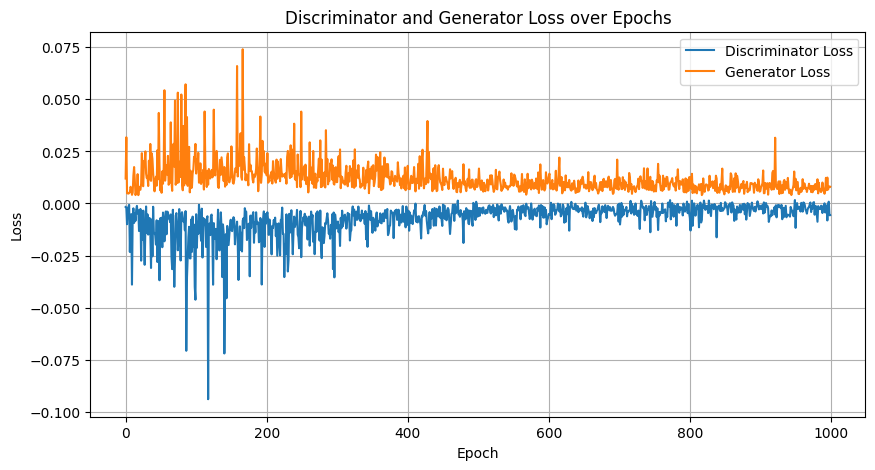

In [27]:
# Plotting the losses
import matplotlib.pyplot as plt # Import matplotlib

plt.figure(figsize=(10, 5))
plt.plot(range(epochs), d_losses, label='Discriminator Loss')
plt.plot(range(epochs), g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator and Generator Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()